
# Brewery Analysis: Machine Learning



---



*  Data is preprocessed and cleaned by removing unneeded columns, merging zip code/cities datasets, and limiting dataset to the top 1,000 most populated cities.
*  To obtain the best possible predictive results, preliminary features should be explored, engineered, and carefully selected. Possible preliminary features for this model could be average income per zipcode, income per capita, and clothing stores per brewery count.
*  The importance of correlation between breweries and outdoor clothing stores will drive which features will be engineered and selected, ultimately answering the hypthesis.
* (How the data was trained and tested)
* A linear regression model was chosen to best illustrate correlation between brewery location and outdoor clothing store location. Is there a strong relationship between the two? The benefits of using a linear regression is readability and abiility to answer basic questions. Limitations of a linear regression model will be sensitivity to outliers.





In [40]:
# Import dependencies

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from database_connection import ENGINE

# Test Linear Regression Model

In [44]:
X, y = make_regression(n_samples=100, n_features=1, random_state=24, noise=20, bias=50.0)

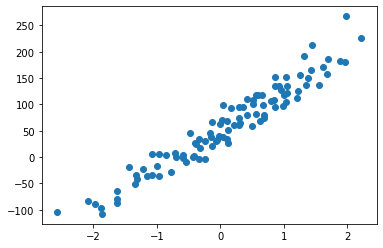

In [45]:
plt.scatter(X, y)

In [46]:
model = LinearRegression()
model

LinearRegression()

In [47]:
model.fit(X, y)
print(model)

LinearRegression()


In [48]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 

Weight coefficients:  [73.68622249]
y-axis intercept:  52.35050319965709


In [49]:
predictions = model.predict(X)
print(f"True output: {y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y[0]}")

True output: 51.573180999075355
Predicted output: 61.05269396989403
Prediction Error: 9.479512970818675


In [50]:
pd.DataFrame({"Predicted": predictions, "Actual": y, "Error": predictions - y})[["Predicted", "Actual", "Error"]]

,Predicted,Actual,Error
0,61.052694,51.573181,9.479513
1,116.539022,135.744467,-19.205445
2,-45.354712,-34.665692,-10.689020
3,-19.366764,6.805878,-26.172642
4,120.974797,134.426874,-13.452077
...,...,...,...
95,111.587291,106.903818,4.683473
96,96.719525,118.261070,-21.541545
97,191.563874,181.988316,9.575558
98,21.512531,3.015834,18.496697


# Data Selection

In [24]:
# Connect to needed databases 
# Connect to zip codes - cleaned database

zip_codes_cleaned_query = '''
    SELECT *
    FROM zip_codes_cleaned
'''

zip_codes = pd.read_sql_query(
    zip_codes_cleaned_query,
    con=ENGINE
)
# Connect to breweries database

breweries_query = '''
    SELECT *
    FROM breweries
'''

breweries = pd.read_sql_query(
    breweries_query,
    con=ENGINE
)

# Connect to outdoor clothing database

outdoor_query = '''
    SELECT *
    FROM outdoor
'''

outdoor = pd.read_sql_query(
    outdoor_query,
    con=ENGINE
)

In [25]:
zip_codes.sample(10)

,zip_code,city,state,county,latitude,longitude,irs_estimated_population
7324,33185,Miami,FL,Miami-Dade County,25.73,-80.45,27380
23762,83641,Melba,ID,Canyon County,43.36,-116.55,3300
19463,68789,Winnetoon,NE,Knox County,42.51,-97.96,183
23031,80026,Lafayette,CO,Boulder County,39.99,-105.09,29430
5927,29203,Columbia,SC,Richland County,34.10,-81.04,29930
19582,68981,Upland,NE,Franklin County,40.31,-98.90,300
815,12748,Jeffersonville,NY,Sullivan County,41.78,-74.93,1590
15794,58577,Washburn,ND,McLean County,47.29,-101.02,1640
15771,58542,Hague,ND,Emmons County,46.02,-99.99,210
8159,36255,Cragford,AL,Clay County,33.21,-85.69,730


In [22]:
# Remove yelp id and closed columns from outdoor/brewery dataframe

breweries_df = breweries.drop(['yelp_id', 'is_closed'], axis=1)
outdoor_df = outdoor.drop(['yelp_id', 'is_closed'], axis=1)

In [38]:
breweries_df=breweries_df.rename(columns={"name": "brewery", "rating": "brewery_rating"})

In [39]:
breweries_df.sample(10)

,brewery,lat,lng,city,business_type,brewery_rating,zip_code,state
130,One Trick Pony Brewery,41.571930,-87.570969,Lansing,breweries,4.5,60438,IL
252,Beaver Street Brewery & Whistle Stop Cafe,35.196550,-111.651440,Flagstaff,brewpubs,4.0,86001,AZ
414,The Laird Arcade Brewery,41.114260,-83.176680,Tiffin,breweries,3.5,44883,OH
3,Parkway Market & Spirits,33.729940,-116.198760,Indio,beer_and_wine,4.5,92203,CA
393,Brew Garden,41.307922,-81.814339,Strongsville,tradamerican,2.5,44136,OH
17,Three Tigers Brewing Company,40.068667,-82.518186,Granville,vietnamese,4.0,43023,OH
155,Gate City Brewing Company,34.023693,-84.362181,Roswell,breweries,4.0,30075,GA
401,Findlay Brewing Company,41.037530,-83.647910,Findlay,breweries,4.0,45840,OH
282,Culture Brewing,33.885511,-118.409133,Manhattan Beach,breweries,4.0,90266,CA
71,Stormhouse Brewing,26.834700,-80.060410,North Palm Beach,brewpubs,4.0,33408,FL


In [36]:
outdoor_df=outdoor_df.rename(columns={"name": "outdoor_store", "rating": "outdoor_rating"})

In [37]:
outdoor_df.sample(10)

,outdoor_store,lat,lng,city,business_type,outdoor_rating,zip_code,state
197,Sisu,33.913504,-117.931691,La Habra,menscloth,5.0,90631,CA
143,DICK'S Sporting Goods,33.953100,-84.231900,Norcross,sportswear,2.5,30092,GA
342,Appalachian Outfitters,41.219680,-81.492830,Peninsula,outdoorgear,3.0,44264,OH
253,Pilot Outfitters,34.014116,-118.449901,Santa Monica,outdoorgear,5.0,90405,CA
331,Northwest Outdoor Center,47.638281,-122.340328,Seattle,boating,4.5,98109,WA
339,Geiger's,41.485300,-81.798740,Lakewood,sportgoods,4.5,44107,OH
281,Big 5 Sporting Goods,34.470000,-117.247020,Apple Valley,huntingfishingsupplies,3.0,92308,CA
171,Sonoma Outfitters,38.445305,-122.686475,Santa Rosa,sportswear,3.0,95405,CA
67,Ocean Magic Surf Shop,26.932461,-80.078325,Jupiter,sportswear,4.0,33477,FL
4,The Climbing Life Guides,34.111679,-116.330658,Joshua Tree,climbing,5.0,92252,CA


In [ ]:
# Group dataframe based on number of breweries and location

In [ ]:
# Merge dataframe with demographic infro dataframe grouped by location
brewery_clothing_df = brewery_df.merge(clothing_df, )

# Data Processing

In [ ]:
# Transform String Columns(Onehotencoder)

In [ ]:
# Scale data if needed (StandardScaler)
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()

In [ ]:
brewery_scaled = data_scaler.fit(encoded_df)

brewery_scaled[:5]

# Data Transformation

In [ ]:
# Save Cleaned Data to csv

In [ ]:
# Export cleaned data csv to sql table

In [ ]:
# Set X and y 
# X = demographic info + number of Breweries per location(zipcode tabulation area?)
# y = number of stores

In [ ]:
# traintestsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [ ]:
# Create an instance of the model(LinearRegression)
model = LinearRegression()

In [ ]:
# Train the model with the dataset 
model.fit(X_train,y_train)

In [ ]:
# Create predictions
predictions = model.predict(X_test)

print(predictions.shape)

In [ ]:
# Validate the model
# accuracy_score
acc_score = accuracy_score(y_test, predictions)

# confusion_matrix/classification_report
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

In [ ]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
# Find impact of different variables